# Overview: 

This notebook is created to do tasks given in issue no #9: [Comparing test sample classifications between models](https://github.com/mozilla/PRESC/issues/8)


## Task

- compare the classification results
    * Develop a visualization
    * Split out Misclassifications under either model




In [1]:
# Import basic libraries
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# import visualization libraries
import seaborn as sns
import matplotlib.pyplot as plt
from ggplot import *
%matplotlib inline

#importing libraries for Decision tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, make_scorer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold 

from sklearn.utils import resample
from imblearn.over_sampling import SMOTE

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier , GradientBoostingClassifier, AdaBoostClassifier
from xgboost import XGBClassifier
from sklearn.metrics import f1_score

In [2]:
df = pd.read_csv("../../datasets/defaults.csv")

In [3]:
df = df.rename(columns={'defaulted': 'def_pay','pay_0': 'pay_1'})
df.head()

,id,limit_bal,sex,education,marriage,age,pay_1,pay_2,pay_3,pay_4,...,bill_amt4,bill_amt5,bill_amt6,pay_amt1,pay_amt2,pay_amt3,pay_amt4,pay_amt5,pay_amt6,def_pay
0,1,20000,2,2,1,24,2,2,-1,-1,...,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,-1,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2,1,37,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2,1,57,-1,0,-1,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


# Machine Learning Model


**How do model performance be measured**

- During training we want the model to learn just the right level of rules for classification
- If model learns more detailed rules than necessary, it will make correct predictions on existing data but incorrect predictions on new data
- If model learns less detailed rules than necessary, it will make incorrect predicitons on existing data as well as new data


**Held Out Data Sample Setup**

- To evaluate if the model has learnt the right level of rules: 
 - we hide part of labeled data, called test data, from training process
 - train the model on remaining available data called training data
 - evaluate model performance on training data
 - evaluate model performance on test data
 - ensure that performance is as high as possible on test data while being similar to performance on training data


This is a classification problem and this means that we can use the following algorithms:

- Logistic regression
- Decision tree
- Random forest
- Support Vector Classifications
- Stocastic Gradient Descend
- Nearest Neighbours Classifiers
- Gaussian Process Classification
- Other ensemble
- Neural Network Models
- XGBoost

First I will work with decision tree. 


## Decision tree

Decision Trees are a class of very powerful Machine Learning model cable of achieving high accuracy in many tasks while being highly interpretable. What makes decision trees special in the realm of ML models is really their clarity of information representation. The *knowledge* learned by a decision tree through training is directly formulated into a hierarchical structure. This structure holds and displays the knowledge in such a way that it can easily be understood, even by non-experts.


The Tree is very easy to use and imagine, it can handle both numerical and categorical variables, but it is easy to fall into the trap of overfitting (i.e. creating a very complex model that perfectly describes training set but fails in predicting). It is also said to be senstive to small changes in the data, leading to different results. For this reason, it is common to use ensembles such as Random Forest to avoid this risk.

There are a few parameters to be settle for the classifier, such as the function to determine the quality of a split, or how deep the tree has to be. We will first test it with a random choice of those parameters and then see a better process.

Decison trees create a rules in form of a tree like flowchart. Decision trees are available in sklearn.tree library in form of class DecisionTreeClassifier.

In [4]:
# creating the target variable
y = df['def_pay'].copy()
y.sample(5)

4246     0
28648    0
9709     0
21521    0
15323    0
Name: def_pay, dtype: int64

In [5]:
# creating the features, which now will be everything in the original df
features = ['limit_bal', 'sex', 'education', 'marriage', 'age', 'pay_1', 'pay_2',
       'pay_3', 'pay_4', 'pay_5', 'pay_6', 'bill_amt1', 'bill_amt2',
       'bill_amt3', 'bill_amt4', 'bill_amt5', 'bill_amt6', 'pay_amt1',
       'pay_amt2', 'pay_amt3', 'pay_amt4', 'pay_amt5', 'pay_amt6']
X = df[features].copy()
X.columns

Index(['limit_bal', 'sex', 'education', 'marriage', 'age', 'pay_1', 'pay_2',
       'pay_3', 'pay_4', 'pay_5', 'pay_6', 'bill_amt1', 'bill_amt2',
       'bill_amt3', 'bill_amt4', 'bill_amt5', 'bill_amt6', 'pay_amt1',
       'pay_amt2', 'pay_amt3', 'pay_amt4', 'pay_amt5', 'pay_amt6'],
      dtype='object')

Here I will train on 80% of the data and test on the remaining 20%. I chose the **80:20** ratio, training/validation split because this ratio gives the better result than other ratios, prevents overtraining of neural networks.

In [6]:
# split the df into train and test, it is important these two do not communicate during the training
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [7]:
#createing the classifier
classifier = DecisionTreeClassifier(max_depth=10, random_state=14) 
# training the classifier
classifier.fit(X_train, y_train)
# doing predictions on the test
predictions = classifier.predict(X_test)


# see how good we did on the test
accuracy_score(y_true = y_test, y_pred = predictions)

0.812

**Accuracy: 81%**

Here I got the accuray 81% which is a result of a random choices on the parameters. 

Now trying overfitting by increasing the maximum depth of the tree.

In [8]:
classifier = DecisionTreeClassifier(max_depth=100, random_state=14) 
classifier.fit(X_train, y_train)
predictions = classifier.predict(X_test)
accuracy_score(y_true = y_test, y_pred = predictions)

0.7231666666666666

So, we can see the accuracy has droped a lot.
To get the better parameters for this model, I am going to use GridSearchCV. 
GridSearchCV implements a “fit” and a “score” method. It also implements “predict”, “predict_proba”, “decision_function”, “transform” and “inverse_transform” if they are implemented in the estimator used.
Here, the more I complicate the grid, the longer it takes, because it is running it every time with a different combination of parameters.

Parameters I had used for DecisionTreeClassifier: 

- **criterion** can be gini (measures how often a randomly chosen element would be incorrectly identified) or entropy (measures the information contained by each attribute, thus we estimate the reduction in entropy due to sorting on the attribute)
- **max depth** is the maximum amount of steps the tree should do
- **max leaf** nodes maximum number of nodes
- **min_samples_split** a limit to stop further splitting, useful to avoid overfitting
- **random_state** is the seed used by the random number generator

In [9]:
# define the parameters grid
param_grid = {'max_depth': np.arange(3, 10),
             'criterion' : ['gini','entropy'],
             'max_leaf_nodes': [5,10,20,100],
             'min_samples_split': [2, 5, 10, 20]}

# create the grid
grid_tree = GridSearchCV(DecisionTreeClassifier(), param_grid, cv = 5, scoring= 'accuracy')
# the cv option will be clear in a few cells

#training
grid_tree.fit(X_train, y_train)
#let's see the best estimator
print(grid_tree.best_estimator_)
#with its score
print(np.abs(grid_tree.best_score_))

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3,
            max_features=None, max_leaf_nodes=20,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=20,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')
0.8212916666666666


In [10]:
classifier = DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3,
            max_features=None, max_leaf_nodes=20,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=20,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')
classifier.fit(X_train, y_train)
predictions = classifier.predict(X_test)
accuracy_score(y_true = y_test, y_pred = predictions)

0.821

The accuracy got increased **0.07%** just by choosing the right parameters..

To cross validate, I will do another thing. I will use **Kfold**. 

K-fold cross-validation is a systematic process for repeating the train/test split procedure multiple times, in order to reduce the variance associated with a single trial of train/test split.

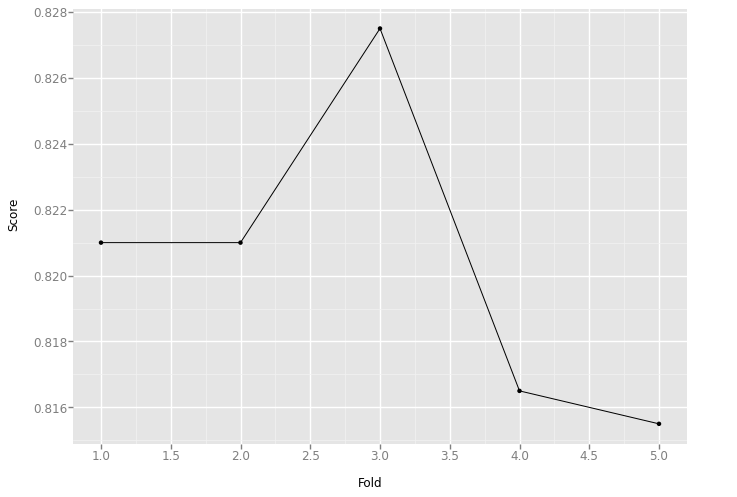

<ggplot: (-9223371895678723419)>


In [11]:
kf = KFold(n_splits=5, random_state=42, shuffle=True)

fold = []
scr = []

for i,(train_index, test_index) in enumerate(kf.split(df)):
    training = df.iloc[train_index,:]
    valid = df.iloc[test_index,:]
    feats = training[features] #defined above
    label = training['def_pay']
    valid_feats = valid[features]
    valid_label = valid['def_pay']
    classifier.fit(feats,label) #it is the last one we run, the best one
    pred = classifier.predict(valid_feats)
    score = accuracy_score(y_true = valid_label, y_pred = pred)
    fold.append(i+1)
    scr.append(score)
    
#create a small df with the scores
performance = pd.DataFrame({'Score':scr,'Fold':fold})
# let's see what we have with ggplot
g = ggplot(performance,aes(x='Fold',y='Score')) + geom_point() + geom_line()
print(g)

Now, this does not mean much now, since it is only one model and, depending on how we split the df into train and test, we get a precision between 0.816 and 0.8275, which may or may not be relevant depending on the purpose of the model. 

Next, I will see the importance of features for this model.

Now I will work on other models.

In [48]:
def get_feature_importance(clsf, ftrs):
    imp = clsf.feature_importances_.tolist()
    feat = ftrs
    result = pd.DataFrame({'feat':feat,'score':imp})
    result = result.sort_values(by=['score'],ascending=False)
    return result

get_feature_importance(classifier, features)

,feat,score
5,pay_1,0.722666
6,pay_2,0.145870
19,pay_amt3,0.049608
11,bill_amt1,0.024832
7,pay_3,0.021724
10,pay_6,0.018298
2,education,0.006637
0,limit_bal,0.003905
8,pay_4,0.003220
18,pay_amt2,0.002195


In [50]:
X = df[['pay_1']].copy()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)
classifier.fit(X_train, y_train) #same classifier as before
predictions = classifier.predict(X_test)
accuracy_score(y_true = y_test, y_pred = predictions)

0.8193333333333334

Now, I will use the f1-score, which takes into account the false positives, the false negatives etc.

So we define the precision as TP/(TP+FP) and recall as TP/(TP+FN) and we have F1 = 2 (Prec Rec) / (Prec + Rec)

In [53]:
# import the tool
from sklearn.metrics import f1_score
#recreate the model and evaluate it
X = df[features].copy()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)
classifier.fit(X_train, y_train) #same classifier as before
predictions = classifier.predict(X_test)
f1_score(y_true = y_test, y_pred = predictions)

0.4683168316831683

In [57]:
 #True Positive (TP): we predict a label of 1 (positive), and the true label is 1.
TP = np.sum(np.logical_and(predictions == 1, y_test == 1))
 
# True Negative (TN): we predict a label of 0 (negative), and the true label is 0.
TN = np.sum(np.logical_and(predictions == 0, y_test == 0))
 
# False Positive (FP): we predict a label of 1 (positive), but the true label is 0.
FP = np.sum(np.logical_and(predictions == 1, y_test == 0))
 
# False Negative (FN): we predict a label of 0 (negative), but the true label is 1.
FN = np.sum(np.logical_and(predictions == 0, y_test == 1))
 
print('TP: {}, FP: {}, TN: {}, FN: {}'.format(TP,FP,TN,FN))

TP: 488, FP: 260, TN: 4427, FN: 825


In [59]:
param_grid = {'max_depth': np.arange(3, 10),
             'criterion' : ['gini','entropy'],
             'max_leaf_nodes': [5,10,20,100],
             'min_samples_split': [2, 5, 10, 20]}
grid_tree = GridSearchCV(DecisionTreeClassifier(), param_grid, cv = 5, scoring= 'f1')
grid_tree.fit(X_train, y_train)
best = grid_tree.best_estimator_
print(grid_tree.best_estimator_)
print(np.abs(grid_tree.best_score_))
classifier = best
classifier.fit(X_train, y_train)
predictions = classifier.predict(X_test)
print("-------------")
print(f1_score(y_true = y_test, y_pred = predictions))
print(get_feature_importance(classifier, features))
print("-------------")
TP = np.sum(np.logical_and(predictions == 1, y_test == 1))
TN = np.sum(np.logical_and(predictions == 0, y_test == 0))
FP = np.sum(np.logical_and(predictions == 1, y_test == 0))
FN = np.sum(np.logical_and(predictions == 0, y_test == 1))
print('TP: {}, FP: {}, TN: {}, FN: {}'.format(TP,FP,TN,FN))

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=4,
            max_features=None, max_leaf_nodes=20,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')
0.4808469166137819
-------------
0.4735565259582727
         feat     score
5       pay_1  0.700515
6       pay_2  0.139945
19   pay_amt3  0.053490
9       pay_5  0.023149
11  bill_amt1  0.018404
7       pay_3  0.016853
0   limit_bal  0.014510
2   education  0.009847
10      pay_6  0.008586
8       pay_4  0.007819
4         age  0.004113
18   pay_amt2  0.002768
3    marriage  0.000000
1         sex  0.000000
12  bill_amt2  0.000000
13  bill_amt3  0.000000
14  bill_amt4  0.000000
15  bill_amt5  0.000000
16  bill_amt6  0.000000
17   pay_amt1  0.000000
20   pay_amt4  0.000000
21   pay_amt5  0.000000
22   pay_amt6  0.000000
-------------
TP: 488, FP: 

In [63]:
param_grid = {'max_depth': np.arange(3, 10),
             'criterion' : ['gini','entropy'],
             'max_leaf_nodes': [5,10,20,100],
             'min_samples_split': [2, 5, 10, 20],
             'class_weight' : ['balanced']}
grid_tree = GridSearchCV(DecisionTreeClassifier(), param_grid, cv = 5, scoring= 'f1')
grid_tree.fit(X_train, y_train)
best = grid_tree.best_estimator_
print(grid_tree.best_estimator_)
print(np.abs(grid_tree.best_score_))
classifier = best
classifier.fit(X_train, y_train)
predictions = classifier.predict(X_test)
print("-------------")
print(f1_score(y_true = y_test, y_pred = predictions))
print(get_feature_importance(classifier, features))
print("-------------")
TP = np.sum(np.logical_and(predictions == 1, y_test == 1))
TN = np.sum(np.logical_and(predictions == 0, y_test == 0))
FP = np.sum(np.logical_and(predictions == 1, y_test == 0))
FN = np.sum(np.logical_and(predictions == 0, y_test == 1))
print('TP: {}, FP: {}, TN: {}, FN: {}'.format(TP,FP,TN,FN))

DecisionTreeClassifier(class_weight='balanced', criterion='entropy',
            max_depth=3, max_features=None, max_leaf_nodes=20,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')
0.527531438172145
-------------
0.5203784570596798
         feat     score
5       pay_1  0.782776
18   pay_amt2  0.069381
8       pay_4  0.049357
6       pay_2  0.039653
0   limit_bal  0.021069
20   pay_amt4  0.011959
19   pay_amt3  0.011690
7       pay_3  0.006434
2   education  0.004715
11  bill_amt1  0.002967
10      pay_6  0.000000
1         sex  0.000000
12  bill_amt2  0.000000
13  bill_amt3  0.000000
14  bill_amt4  0.000000
15  bill_amt5  0.000000
16  bill_amt6  0.000000
17   pay_amt1  0.000000
9       pay_5  0.000000
4         age  0.000000
3    marriage  0.000000
21   pay_amt5  0.000000
22   pay_amt6  0.000000
-------------
TP: 7

Here is had used some other ways by changing the peramiters, but this gives me the best result. 

# Data Cleaning
Data cleaning helps to get rid of null values, noice and make the data handlable for models. For that, it is necessary to do data cleaning.


In [64]:
fil = (df.education == 5) | (df.education == 6) | (df.education == 0)
df.loc[fil, 'education'] = 4
df.education.value_counts()

2    14030
1    10585
3     4917
4      468
Name: education, dtype: int64

In [65]:
df.loc[df.marriage == 0, 'marriage'] = 3
df.marriage.value_counts()

2    15964
1    13659
3      377
Name: marriage, dtype: int64

In [12]:
# create the training df by remerging X_train and y_train
df_train = X_train.join(y_train)
df_train.sample(10)

,limit_bal,sex,education,marriage,age,pay_1,pay_2,pay_3,pay_4,pay_5,...,bill_amt4,bill_amt5,bill_amt6,pay_amt1,pay_amt2,pay_amt3,pay_amt4,pay_amt5,pay_amt6,def_pay
12271,280000,2,1,2,32,-1,-1,-1,0,-1,...,3008,8988,11547,23871,14907,0,8988,11547,19826,0
4169,60000,1,2,3,46,0,0,2,2,2,...,27473,29176,28242,3000,2000,0,2289,0,1500,1
10522,50000,1,2,2,24,0,0,0,0,0,...,16607,17186,17749,2000,2000,1000,1000,1000,1000,0
20515,100000,1,2,1,30,-1,-1,-1,-1,-1,...,1416,416,416,416,1005,1416,416,416,0,0
1505,350000,1,1,1,70,0,0,0,0,0,...,57583,45554,37063,3371,2089,3008,1300,1500,1372,0
23715,280000,2,1,1,47,4,3,2,2,2,...,131222,132758,135654,3000,6000,4500,5000,5000,5000,1
15565,290000,1,2,1,43,-1,-1,2,0,0,...,3710,3848,4285,1930,0,2000,200,500,0,0
6942,20000,1,2,2,27,1,-2,-2,-2,-2,...,0,0,0,0,0,0,0,0,0,1
12605,60000,1,3,2,29,0,0,0,0,0,...,7920,8472,8735,7662,1269,1908,1000,727,0,0
14423,50000,2,3,1,24,-1,-1,2,0,-1,...,13555,2338,41191,3000,15,587,2338,41191,18957,0


In [13]:
# Separating majority and minority classes
df_majority = df_train[df_train.def_pay==0]
df_minority = df_train[df_train.def_pay==1]

print(df_majority.def_pay.count())
print("-----------")
print(df_minority.def_pay.count())
print("-----------")
print(df_train.def_pay.value_counts())

18677
-----------
5323
-----------
0    18677
1     5323
Name: def_pay, dtype: int64


In [14]:
# Upsampling minority class
df_minority_upsampled = resample(df_minority, 
                                 replace=True,     # sample with replacement
                                 n_samples=18677,    # to match majority class
                                 random_state=587) # reproducible results
# Combining majority class with upsampled minority class
df_upsampled = pd.concat([df_majority, df_minority_upsampled])
# Displaying new class counts
df_upsampled.def_pay.value_counts()

1    18677
0    18677
Name: def_pay, dtype: int64

In [15]:
# Downsampling majority class
df_majority_downsampled = resample(df_majority, 
                                 replace=False,    # sample without replacement
                                 n_samples=5323,     # to match minority class
                                 random_state=587) # reproducible results
# Combining minority class with downsampled majority class
df_downsampled = pd.concat([df_majority_downsampled, df_minority])
# Displaying new class counts
df_downsampled.def_pay.value_counts()

1    5323
0    5323
Name: def_pay, dtype: int64

The upsample has the disadvantage of increasing the likelihood of overfitting because it replicates the minority class event. It usually outperform the downsampling. The downsample can discard potentially useful information and the sample can be biased, but it helps improving the run time.

To create a syntetic sample I will use the **SMOTE algorithm**, which is an oversampling method which creates syntetic samples from the minority class instead of creating copies. It selects 2 or more similar instances and perturb them one at a time by random amount. This techniques should avoid overfitting problems but it risks adding noise to the model

In [16]:
sm = SMOTE(random_state=589, ratio = 1.0)
X_SMOTE, y_SMOTE = sm.fit_sample(X_train, y_train)
print(len(y_SMOTE))
print(y_SMOTE.sum())

37354
18677


So now I have 4 training sets:

- X_train, y_train, with their unbalance and their authenticity.
- df_upsample, which is balanced but at overfitting risk
- df_downsample, which will be fast but also potentially useless in terms of predictability (the test set is even bigger than it)
- X_SMOTE, y_SMOTE, which is syntetic and I don't really know it but should avoid overfitting

I will do everything 4 times for all models so that I can see the results and compare them following these steps.

- K-fold evaluation, run on different models should give us an idea on which one is more stable towards splitting of train and test
- Hyperparameter selection, so that we can have the best version of every algorithm
- Training
- Testing



# Algorithm Selection

the most commonly used technique is to use ensambles: combinations of different classifiers that create a more robust model. 

The main "classes" are:

- baggin ensambles: which reduce the chances of overfitting by running a series of uncostrained learners in parallel and combine them
- boosting ensambles: which improve the the flexibility of simple models by running a series of constrained learners in sequence. Each one of them will learn from the mistakes of the previous one. At the end it combines them in one unconstrained learner. 

For **Random Forest**, It trains on a large number of trees and combine them. The randomness comes from the fact that each tree is allowed to choose from a random subset of features to split on and each tree is trained on a random subset of observations.

For the **Gradient Tree Boosting**, it tries to minimize a loss function (difference between the real value and output of the learner) using the gradient descent method. Then there is **Ada-Boost** that trains the learners to make strong prediction by focusing on examples harder and harder to classify. This is done by assigning weights to the instances and increasing the one of missclassified one.

In [17]:
# classifier list for the normal training set
clf_list = [DecisionTreeClassifier(max_depth = 3, class_weight = "balanced"), 
            RandomForestClassifier(n_estimators = 100, class_weight = "balanced"), 
            AdaBoostClassifier(DecisionTreeClassifier(max_depth = 3, class_weight = "balanced"),
                               n_estimators = 100), 
            GradientBoostingClassifier(), 
            XGBClassifier()
           ]
# the parameters are set in order to have the same kind of tree every time

0
DecisionTreeClassifier
RandomForestClassifier
AdaBoostClassifier
GradientBoostingClassifier
XGBClassifier
1
DecisionTreeClassifier
RandomForestClassifier
AdaBoostClassifier
GradientBoostingClassifier
XGBClassifier
2
DecisionTreeClassifier
RandomForestClassifier
AdaBoostClassifier
GradientBoostingClassifier
XGBClassifier
3
DecisionTreeClassifier
RandomForestClassifier
AdaBoostClassifier
GradientBoostingClassifier
XGBClassifier
4
DecisionTreeClassifier
RandomForestClassifier
AdaBoostClassifier
GradientBoostingClassifier


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

XGBClassifier


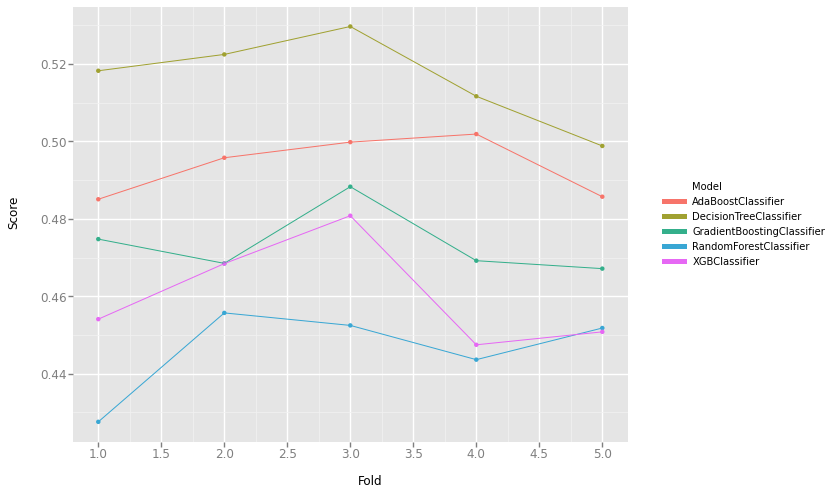

<ggplot: (141176052358)>


In [18]:
# using Kfold to evaluate the normal training set
kf = KFold(n_splits=5,random_state=42,shuffle=True)

mdl = []
fold = []
scr = []

for i,(train_index, test_index) in enumerate(kf.split(df_train)):
    training = df.iloc[train_index,:]
    valid = df.iloc[test_index,:]
    print(i)
    for clf in clf_list:
        model = clf.__class__.__name__
        feats = training[features] 
        label = training['def_pay']
        valid_feats = valid[features]
        valid_label = valid['def_pay']
        clf.fit(feats,label) 
        pred = clf.predict(valid_feats)
        score = f1_score(y_true = valid_label, y_pred = pred)
        fold.append(i+1)
        scr.append(score)
        mdl.append(model)
        print(model)
    
#creating a small df with the scores
performance = pd.DataFrame({'Model': mdl, 'Score':scr,'Fold':fold})
g_normal = ggplot(performance,aes(x='Fold',y='Score',group = 'Model',color = 'Model')) + geom_point() + geom_line()
print(g_normal)

In [19]:
# classifier list for the downsampled training set
clf_list = [DecisionTreeClassifier(max_depth = 3), 
            RandomForestClassifier(n_estimators = 100), 
            AdaBoostClassifier(DecisionTreeClassifier(max_depth = 3), n_estimators = 100), 
            GradientBoostingClassifier(), 
            XGBClassifier()
           ]
# the parameters are set in order to have the same kind of tree every time

0
DecisionTreeClassifier
RandomForestClassifier
AdaBoostClassifier
GradientBoostingClassifier
XGBClassifier
1
DecisionTreeClassifier
RandomForestClassifier
AdaBoostClassifier
GradientBoostingClassifier
XGBClassifier
2
DecisionTreeClassifier
RandomForestClassifier
AdaBoostClassifier
GradientBoostingClassifier
XGBClassifier
3
DecisionTreeClassifier
RandomForestClassifier
AdaBoostClassifier
GradientBoostingClassifier
XGBClassifier
4
DecisionTreeClassifier
RandomForestClassifier
AdaBoostClassifier
GradientBoostingClassifier


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

XGBClassifier


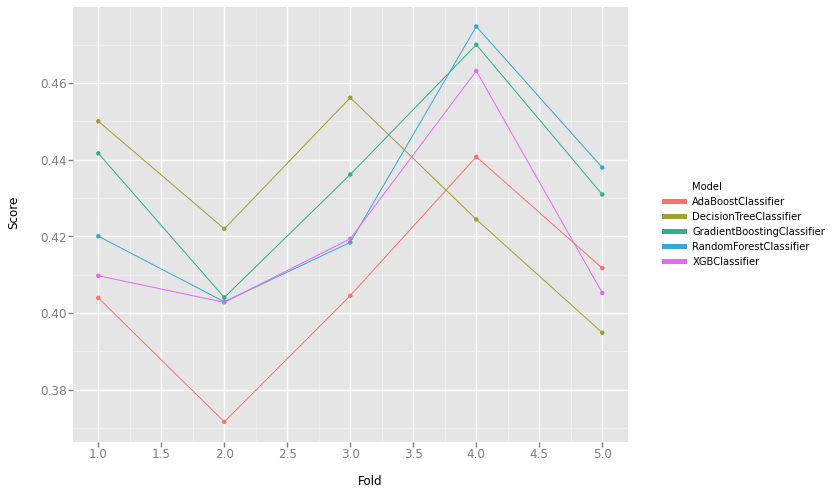

In [20]:
# using Kfold to evaluate the upsampled training set
kf = KFold(n_splits=5,random_state=42,shuffle=True)

mdl = []
fold = []
scr = []

for i,(train_index, test_index) in enumerate(kf.split(df_downsampled)):
    training = df.iloc[train_index,:]
    valid = df.iloc[test_index,:]
    print(i)
    for clf in clf_list:
        model = clf.__class__.__name__
        feats = training[features] #defined above
        label = training['def_pay']
        valid_feats = valid[features]
        valid_label = valid['def_pay']
        clf.fit(feats,label) 
        pred = clf.predict(valid_feats)
        score = f1_score(y_true = valid_label, y_pred = pred)
        fold.append(i+1)
        scr.append(score)
        mdl.append(model)
        print(model)
    
#create a small df with the scores
performance = pd.DataFrame({'Model': mdl, 'Score':scr,'Fold':fold})
g_downsampled = ggplot(performance,aes(x='Fold',y='Score',group = 'Model',color = 'Model')) + geom_point() + geom_line()
print(g_downsampled)

## Random Forest 

In [21]:
# normal training set
param_grid = {'n_estimators': [200, 400, 600, 1000], # It is going to be a long search
              'criterion': ['entropy', 'gini'],
              'class_weight' : ['balanced'], 'n_jobs' : [-1]} #use all the computational power you have
acc_scorer = make_scorer(f1_score)
grid_forest = GridSearchCV(RandomForestClassifier(), param_grid, scoring = acc_scorer, cv=5)
%time grid_forest = grid_forest.fit(X_train, y_train)
print(grid_forest.best_estimator_)
print(grid_forest.best_score_)
forest_normal = grid_forest.best_estimator_

<ggplot: (-9223371895677623548)>
Wall time: 15min 23s
RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='entropy', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=600, n_jobs=-1, oob_score=False,
            random_state=None, verbose=0, warm_start=False)
0.465152035473864


In [22]:
forest_normal = RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='entropy', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=400, n_jobs=-1, oob_score=False,
            random_state=None, verbose=0, warm_start=False)
print(0.449643478486)

0.449643478486


In [23]:
y_upsampled = df_upsampled.def_pay
X_upsampled = df_upsampled.drop(['def_pay'], axis= 1)

In [24]:
# upsampled training set
param_grid = {'n_estimators': [200, 400, 600, 1000],
              'criterion': ['entropy', 'gini'], 'n_jobs' : [-1]}
acc_scorer = make_scorer(f1_score)
grid_forest = GridSearchCV(RandomForestClassifier(), param_grid, scoring = acc_scorer, cv=5)
%time grid_forest = grid_forest.fit(X_upsampled, y_upsampled)
print(grid_forest.best_estimator_)
print(grid_forest.best_score_)
forest_upsampled = grid_forest.best_estimator_

Wall time: 20min 9s
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=600, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
0.9385748419676255


In [25]:
#cell added because on Kaggle it takes too much time to run
forest_upsampled = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=600, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
print(0.93295704261)

0.93295704261


In [26]:
y_downsampled = df_downsampled.def_pay
X_downsampled = df_downsampled.drop(['def_pay'], axis = 1)

In [27]:
# downsampled training set
param_grid = {'n_estimators': [200, 400, 600, 1000],
              'criterion': ['entropy', 'gini'], 'n_jobs' : [-1]}
acc_scorer = make_scorer(f1_score)
grid_forest = GridSearchCV(RandomForestClassifier(), param_grid, scoring = acc_scorer, cv=5)
%time grid_forest = grid_forest.fit(X_downsampled, y_downsampled)
print(grid_forest.best_estimator_)
print(grid_forest.best_score_)
forest_downsampled = grid_forest.best_estimator_

Wall time: 6min 8s
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=400, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
0.6893534034933633


In [28]:
forest_downsampled = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
print(0.686692645307)

0.686692645307


In [29]:
# SMOTE training set
param_grid = {'n_estimators': [200, 400, 600, 1000],
              'criterion': ['entropy', 'gini'], 'n_jobs' : [-1]}
acc_scorer = make_scorer(f1_score)
grid_forest = GridSearchCV(RandomForestClassifier(), param_grid, scoring = acc_scorer, cv=5)
%time grid_forest = grid_forest.fit(X_SMOTE, y_SMOTE)
print(grid_forest.best_estimator_)
print(grid_forest.best_score_)
forest_SMOTE = grid_forest.best_estimator_

Wall time: 21min 4s
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=400, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
0.8324839892169879


In [30]:
forest_SMOTE = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=600, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
print(0.831423121548)

0.831423121548


# Ada Boost Classifier 


In [31]:
# normal training set
param_grid = {'n_estimators': [200,300],
              'algorithm': ['SAMME', 'SAMME.R'],
              'learning_rate' : [0.5, 0.75, 1.0]}
acc_scorer = make_scorer(f1_score)
grid_ada = GridSearchCV(AdaBoostClassifier(DecisionTreeClassifier(class_weight = "balanced")), 
                        param_grid, scoring = acc_scorer, cv=5)
%time grid_ada = grid_ada.fit(X_train, y_train)
print(grid_ada.best_estimator_)
print(grid_ada.best_score_)
ada_normal = grid_ada.best_estimator_


Wall time: 57min 57s
AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
          learning_rate=0.5, n_estimators=300, random_state=None)
0.43887982009449844


In [32]:
ada_normal = AdaBoostClassifier(algorithm='SAMME',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
          learning_rate=0.75, n_estimators=300, random_state=None)
print(0.408435692436)

0.408435692436


In [33]:
# upsampled training set

param_grid = {'n_estimators': [200,300],
              'algorithm': ['SAMME', 'SAMME.R'],
              'learning_rate' : [0.5, 0.75, 1.0]}
acc_scorer = make_scorer(f1_score)
grid_ada = GridSearchCV(AdaBoostClassifier(), param_grid, scoring = acc_scorer, cv=5)
%time grid_ada = grid_ada.fit(X_upsampled, y_upsampled)
print(grid_ada.best_estimator_)
print(grid_ada.best_score_)
ada_upsampled = grid_ada.best_estimator_

Wall time: 13min 27s
AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=300, random_state=None)
0.6901436580100705


In [34]:
ada_upsampled = AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=300, random_state=None)
print(0.689430792925)

0.689430792925


In [35]:
# downsampled training set
param_grid = {'n_estimators': [200,300],
              'algorithm': ['SAMME', 'SAMME.R'],
              'learning_rate' : [0.5, 0.75, 1.0]}
acc_scorer = make_scorer(f1_score)
grid_ada = GridSearchCV(AdaBoostClassifier(), param_grid, scoring = acc_scorer, cv=5)
%time grid_ada = grid_ada.fit(X_downsampled, y_downsampled)
print(grid_ada.best_estimator_)
print(grid_ada.best_score_)
ada_downsampled = grid_ada.best_estimator_

Wall time: 3min 58s
AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=300, random_state=None)
0.6801418231121859


In [36]:
ada_downsampled = AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=200, random_state=None)
print(0.673783146613)

0.673783146613


In [37]:
# SMOTE training set
param_grid = {'n_estimators': [200,300],
              'algorithm': ['SAMME', 'SAMME.R'],
              'learning_rate' : [0.5, 0.75, 1.0]}
acc_scorer = make_scorer(f1_score)
grid_ada = GridSearchCV(AdaBoostClassifier(), param_grid, scoring = acc_scorer, cv=5)
%time grid_ada = grid_ada.fit(X_SMOTE, y_SMOTE)
print(grid_ada.best_estimator_)
print(grid_ada.best_score_)
ada_SMOTE = grid_ada.best_estimator_


Wall time: 16min 27s
AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=0.75, n_estimators=300, random_state=None)
0.7432626626103367


In [38]:
ada_SMOTE = AdaBoostClassifier(algorithm='SAMME', base_estimator=None, learning_rate=0.5,
          n_estimators=200, random_state=None)
print(0.797835003041)

0.797835003041


# Gradient Boost


In [39]:
# normal training set
param_grid = {'n_estimators': [200,300],
              'learning_rate' : [0.5, 0.75, 1.0]}
acc_scorer = make_scorer(f1_score)
grid_gbc = GridSearchCV(GradientBoostingClassifier(), param_grid, scoring = acc_scorer, cv=5)
%time grid_gbc = grid_gbc.fit(X_train, y_train)
print(grid_gbc.best_estimator_)
print(grid_gbc.best_score_)
gbc_normal = grid_gbc.best_estimator_

Wall time: 3min 44s
GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.5, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=200,
              n_iter_no_change=None, presort='auto', random_state=None,
              subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False)
0.4624924311192019


In [40]:
gbc_normal = GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.5, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=200,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False)
print(0.443888650557)

0.443888650557


In [41]:
#upsampled training set
param_grid = {'n_estimators': [200,300],
              'learning_rate' : [0.5, 0.75, 1.0]}
acc_scorer = make_scorer(f1_score)
grid_gbc = GridSearchCV(GradientBoostingClassifier(), param_grid, scoring = acc_scorer, cv=5)
%time grid_gbc = grid_gbc.fit(X_upsampled, y_upsampled)
print(grid_gbc.best_estimator_)
print(grid_gbc.best_score_)
gbc_upsampled = grid_gbc.best_estimator_

Wall time: 5min 47s
GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=1.0, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=300,
              n_iter_no_change=None, presort='auto', random_state=None,
              subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False)
0.8224780687338221


In [42]:
gbc_upsampled = GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=1.0, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=300,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False)
print(0.831025217754)

0.831025217754


In [43]:
#downsampled training set
param_grid = {'n_estimators': [200,300],
              'learning_rate' : [0.5, 0.75, 1.0]}
acc_scorer = make_scorer(f1_score)
grid_gbc = GridSearchCV(GradientBoostingClassifier(), param_grid, scoring = acc_scorer, cv=5)
%time grid_gbc = grid_gbc.fit(X_downsampled, y_downsampled)
print(grid_gbc.best_estimator_)
print(grid_gbc.best_score_)
gbc_downsampled = grid_gbc.best_estimator_

Wall time: 1min 35s
GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.5, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=200,
              n_iter_no_change=None, presort='auto', random_state=None,
              subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False)
0.674320557824636


In [44]:
gbc_downsampled = GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.5, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=300,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False)
print(0.67183972731)

0.67183972731


In [45]:
param_grid = {'n_estimators': [200,300],
              'learning_rate' : [0.5, 0.75, 1.0]}
acc_scorer = make_scorer(f1_score)
grid_gbc = GridSearchCV(GradientBoostingClassifier(), param_grid, scoring = acc_scorer, cv=5)
%time grid_gbc = grid_gbc.fit(X_SMOTE, y_SMOTE)
print(grid_gbc.best_estimator_)
print(grid_gbc.best_score_)
gbc_SMOTE = grid_gbc.best_estimator_

Wall time: 7min 46s
GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.5, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=300,
              n_iter_no_change=None, presort='auto', random_state=None,
              subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False)
0.7817740031569567


In [46]:
gbc_SMOTE = GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.5, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=200,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False)
print(0.78976849349)

0.78976849349


The common result is that the model trained on the normal dataset, which is unbalanced, gives a lower f1 score. 

This also shows that the one with balanced options do not perform as well as one that learned on a balanced sample. The upsampled learners seem to be more promising but, as mentioned, they fall into the overfitting trap more often.

# Training and testing
It is time to see how well our models perform for real. I will run them all and hopefully see significant differences in how they reach a result.

## Random Forests

In [66]:
# Normal sample training
%time forest_normal.fit(X_train, y_train)
predictions = forest_normal.predict(X_test)
print("-------------")
print("f1 score: {}".format(round(f1_score(y_true = y_test, y_pred = predictions),3)))
print("Accuracy: {}".format(round(accuracy_score(y_true = y_test, y_pred = predictions),3)))
print("-------------")
print(get_feature_importance(forest_normal, features))
print("-------------")
TP = np.sum(np.logical_and(predictions == 1, y_test == 1))
TN = np.sum(np.logical_and(predictions == 0, y_test == 0))
FP = np.sum(np.logical_and(predictions == 1, y_test == 0))
FN = np.sum(np.logical_and(predictions == 0, y_test == 1))
pred = len(predictions)

print('True Positives: {}'.format(TP))
print('False Positive: {}'.format(FP))
print('True Negative: {}'.format(TN))
print('False Negative: {}'.format(FN))
print('Precision: {}'.format(round(TP/(TP+FP),2)))
print('Recall: {}'.format(round(TP/(TP+FN),2)))
print('Problematic ratio: {}'.format(round(FN/(FN+TP),2)))

Wall time: 23.8 s
-------------
f1 score: 0.458
Accuracy: 0.817
-------------
         feat     score
5       pay_1  0.078945
4         age  0.065227
11  bill_amt1  0.064751
0   limit_bal  0.063790
12  bill_amt2  0.056554
17   pay_amt1  0.053796
13  bill_amt3  0.053259
18   pay_amt2  0.052902
15  bill_amt5  0.052014
14  bill_amt4  0.051946
16  bill_amt6  0.051910
19   pay_amt3  0.050707
22   pay_amt6  0.049966
20   pay_amt4  0.047449
21   pay_amt5  0.045696
6       pay_2  0.037236
7       pay_3  0.024114
2   education  0.021344
8       pay_4  0.020988
9       pay_5  0.016649
10      pay_6  0.015771
3    marriage  0.013180
1         sex  0.011807
-------------
True Positives: 464
False Positive: 251
True Negative: 4436
False Negative: 849
Precision: 0.65
Recall: 0.35
Problematic ratio: 0.65


In [67]:
# Upsample training
%time forest_upsampled.fit(X_upsampled, y_upsampled)
predictions = forest_upsampled.predict(X_test)
print("-------------")
print("f1 score: {}".format(round(f1_score(y_true = y_test, y_pred = predictions),3)))
print("Accuracy: {}".format(round(accuracy_score(y_true = y_test, y_pred = predictions),3)))
print("-------------")
print(get_feature_importance(forest_upsampled, features))
print("-------------")
TP = np.sum(np.logical_and(predictions == 1, y_test == 1))
TN = np.sum(np.logical_and(predictions == 0, y_test == 0))
FP = np.sum(np.logical_and(predictions == 1, y_test == 0))
FN = np.sum(np.logical_and(predictions == 0, y_test == 1))
pred = len(predictions)

print('True Positives: {}'.format(TP))
print('False Positive: {}'.format(FP))
print('True Negative: {}'.format(TN))
print('False Negative: {}'.format(FN))
print('Precision: {}'.format(round(TP/(TP+FP),2)))
print('Recall: {}'.format(round(TP/(TP+FN),2)))
print('Problematic ratio: {}'.format(round(FN/(FN+TP),2)))

Wall time: 33.8 s
-------------
f1 score: 0.5
Accuracy: 0.813
-------------
         feat     score
5       pay_1  0.095043
0   limit_bal  0.062834
11  bill_amt1  0.062394
4         age  0.061744
12  bill_amt2  0.054642
17   pay_amt1  0.052980
13  bill_amt3  0.051126
18   pay_amt2  0.050904
14  bill_amt4  0.049552
16  bill_amt6  0.049185
15  bill_amt5  0.048853
19   pay_amt3  0.048753
22   pay_amt6  0.046945
20   pay_amt4  0.045906
21   pay_amt5  0.043033
6       pay_2  0.041136
7       pay_3  0.028819
8       pay_4  0.025556
2   education  0.020359
10      pay_6  0.018390
9       pay_5  0.017931
3    marriage  0.012683
1         sex  0.011231
-------------
True Positives: 562
False Positive: 371
True Negative: 4316
False Negative: 751
Precision: 0.6
Recall: 0.43
Problematic ratio: 0.57


In [68]:
# Downsample training
%time forest_downsampled.fit(X_downsampled, y_downsampled)
predictions = forest_downsampled.predict(X_test)
print("-------------")
print("f1 score: {}".format(round(f1_score(y_true = y_test, y_pred = predictions),3)))
print("Accuracy: {}".format(round(accuracy_score(y_true = y_test, y_pred = predictions),3)))
print("-------------")
print(get_feature_importance(forest_downsampled, features))
print("-------------")
TP = np.sum(np.logical_and(predictions == 1, y_test == 1))
TN = np.sum(np.logical_and(predictions == 0, y_test == 0))
FP = np.sum(np.logical_and(predictions == 1, y_test == 0))
FN = np.sum(np.logical_and(predictions == 0, y_test == 1))
pred = len(predictions)

print('True Positives: {}'.format(TP))
print('False Positive: {}'.format(FP))
print('True Negative: {}'.format(TN))
print('False Negative: {}'.format(FN))
print('Precision: {}'.format(round(TP/(TP+FP),2)))
print('Recall: {}'.format(round(TP/(TP+FN),2)))
print('Problematic ratio: {}'.format(round(FN/(FN+TP),2)))

Wall time: 14.8 s
-------------
f1 score: 0.522
Accuracy: 0.745
-------------
         feat     score
5       pay_1  0.095273
4         age  0.062083
0   limit_bal  0.061923
11  bill_amt1  0.061771
12  bill_amt2  0.053537
17   pay_amt1  0.053043
13  bill_amt3  0.049951
14  bill_amt4  0.049158
18   pay_amt2  0.049146
15  bill_amt5  0.048565
16  bill_amt6  0.048258
19   pay_amt3  0.048093
22   pay_amt6  0.047024
20   pay_amt4  0.044757
21   pay_amt5  0.043661
6       pay_2  0.043116
7       pay_3  0.033075
8       pay_4  0.023405
2   education  0.021446
10      pay_6  0.019287
9       pay_5  0.018119
3    marriage  0.013353
1         sex  0.011959
-------------
True Positives: 838
False Positive: 1057
True Negative: 3630
False Negative: 475
Precision: 0.44
Recall: 0.64
Problematic ratio: 0.36


In [69]:
# SMOTE training
%time forest_SMOTE.fit(X_SMOTE, y_SMOTE)
predictions = forest_SMOTE.predict(X_test)
print("-------------")
print("f1 score: {}".format(round(f1_score(y_true = y_test, y_pred = predictions),3)))
print("Accuracy: {}".format(round(accuracy_score(y_true = y_test, y_pred = predictions),3)))
print("-------------")
print(get_feature_importance(forest_SMOTE, features))
print("-------------")
TP = np.sum(np.logical_and(predictions == 1, y_test == 1))
TN = np.sum(np.logical_and(predictions == 0, y_test == 0))
FP = np.sum(np.logical_and(predictions == 1, y_test == 0))
FN = np.sum(np.logical_and(predictions == 0, y_test == 1))
pred = len(predictions)

print('True Positives: {}'.format(TP))
print('False Positive: {}'.format(FP))
print('True Negative: {}'.format(TN))
print('False Negative: {}'.format(FN))
print('Precision: {}'.format(round(TP/(TP+FP),2)))
print('Recall: {}'.format(round(TP/(TP+FN),2)))
print('Problematic ratio: {}'.format(round(FN/(FN+TP),2)))

Wall time: 39.8 s
-------------
f1 score: 0.5
Accuracy: 0.783
-------------
         feat     score
5       pay_1  0.080047
0   limit_bal  0.059071
11  bill_amt1  0.057699
6       pay_2  0.055065
17   pay_amt1  0.053463
4         age  0.052700
18   pay_amt2  0.049354
12  bill_amt2  0.048220
19   pay_amt3  0.045559
22   pay_amt6  0.045288
13  bill_amt3  0.045041
14  bill_amt4  0.044191
20   pay_amt4  0.043940
15  bill_amt5  0.043062
16  bill_amt6  0.042882
21   pay_amt5  0.040647
7       pay_3  0.037510
3    marriage  0.032839
1         sex  0.028970
8       pay_4  0.026404
2   education  0.025902
9       pay_5  0.021521
10      pay_6  0.020623
-------------
True Positives: 652
False Positive: 643
True Negative: 4044
False Negative: 661
Precision: 0.5
Recall: 0.5
Problematic ratio: 0.5


## Ada Boost


In [70]:
# Normal sample training
%time ada_normal.fit(X_train, y_train)
predictions = ada_normal.predict(X_test)
print("-------------")
print("f1 score: {}".format(round(f1_score(y_true = y_test, y_pred = predictions),3)))
print("Accuracy: {}".format(round(accuracy_score(y_true = y_test, y_pred = predictions),3)))
print("-------------")
print(get_feature_importance(ada_normal, features))
print("-------------")
TP = np.sum(np.logical_and(predictions == 1, y_test == 1))
TN = np.sum(np.logical_and(predictions == 0, y_test == 0))
FP = np.sum(np.logical_and(predictions == 1, y_test == 0))
FN = np.sum(np.logical_and(predictions == 0, y_test == 1))
pred = len(predictions)

print('True Positives: {}'.format(TP))
print('False Positive: {}'.format(FP))
print('True Negative: {}'.format(TN))
print('False Negative: {}'.format(FN))
print('Precision: {}'.format(round(TP/(TP+FP),2)))
print('Recall: {}'.format(round(TP/(TP+FN),2)))
print('Problematic ratio: {}'.format(round(FN/(FN+TP),2)))

Wall time: 21.9 s
-------------
f1 score: 0.417
Accuracy: 0.782
-------------
         feat     score
5       pay_1  0.173591
4         age  0.077599
0   limit_bal  0.069072
11  bill_amt1  0.068654
18   pay_amt2  0.055801
17   pay_amt1  0.050602
19   pay_amt3  0.050535
20   pay_amt4  0.048605
22   pay_amt6  0.047497
16  bill_amt6  0.045313
21   pay_amt5  0.042993
12  bill_amt2  0.040333
13  bill_amt3  0.037952
15  bill_amt5  0.037938
14  bill_amt4  0.035630
6       pay_2  0.032422
2   education  0.020164
8       pay_4  0.013931
1         sex  0.013074
3    marriage  0.012079
10      pay_6  0.009620
7       pay_3  0.008780
9       pay_5  0.007815
-------------
True Positives: 467
False Positive: 461
True Negative: 4226
False Negative: 846
Precision: 0.5
Recall: 0.36
Problematic ratio: 0.64


In [71]:
# Upsample training
%time ada_upsampled.fit(X_upsampled, y_upsampled)
predictions = ada_upsampled.predict(X_test)
print("-------------")
print("f1 score: {}".format(round(f1_score(y_true = y_test, y_pred = predictions),3)))
print("Accuracy: {}".format(round(accuracy_score(y_true = y_test, y_pred = predictions),3)))
print("-------------")
print(get_feature_importance(ada_upsampled, features))
print("-------------")
TP = np.sum(np.logical_and(predictions == 1, y_test == 1))
TN = np.sum(np.logical_and(predictions == 0, y_test == 0))
FP = np.sum(np.logical_and(predictions == 1, y_test == 0))
FN = np.sum(np.logical_and(predictions == 0, y_test == 1))
pred = len(predictions)

print('True Positives: {}'.format(TP))
print('False Positive: {}'.format(FP))
print('True Negative: {}'.format(TN))
print('False Negative: {}'.format(FN))
print('Precision: {}'.format(round(TP/(TP+FP),2)))
print('Recall: {}'.format(round(TP/(TP+FN),2)))
print('Problematic ratio: {}'.format(round(FN/(FN+TP),2)))

Wall time: 20.9 s
-------------
f1 score: 0.521
Accuracy: 0.751
-------------
         feat     score
18   pay_amt2  0.103333
22   pay_amt6  0.086667
19   pay_amt3  0.086667
16  bill_amt6  0.076667
11  bill_amt1  0.076667
13  bill_amt3  0.063333
15  bill_amt5  0.063333
20   pay_amt4  0.060000
14  bill_amt4  0.053333
17   pay_amt1  0.050000
0   limit_bal  0.046667
12  bill_amt2  0.043333
21   pay_amt5  0.040000
5       pay_1  0.040000
8       pay_4  0.026667
10      pay_6  0.020000
2   education  0.013333
6       pay_2  0.010000
9       pay_5  0.010000
4         age  0.010000
7       pay_3  0.010000
3    marriage  0.006667
1         sex  0.003333
-------------
True Positives: 814
False Positive: 997
True Negative: 3690
False Negative: 499
Precision: 0.45
Recall: 0.62
Problematic ratio: 0.38


In [72]:
# Downsample training
%time ada_downsampled.fit(X_downsampled, y_downsampled)
predictions = ada_downsampled.predict(X_test)
print("-------------")
print("f1 score: {}".format(round(f1_score(y_true = y_test, y_pred = predictions),3)))
print("Accuracy: {}".format(round(accuracy_score(y_true = y_test, y_pred = predictions),3)))
print("-------------")
print(get_feature_importance(ada_downsampled, features))
print("-------------")
TP = np.sum(np.logical_and(predictions == 1, y_test == 1))
TN = np.sum(np.logical_and(predictions == 0, y_test == 0))
FP = np.sum(np.logical_and(predictions == 1, y_test == 0))
FN = np.sum(np.logical_and(predictions == 0, y_test == 1))
pred = len(predictions)

print('True Positives: {}'.format(TP))
print('False Positive: {}'.format(FP))
print('True Negative: {}'.format(TN))
print('False Negative: {}'.format(FN))
print('Precision: {}'.format(round(TP/(TP+FP),2)))
print('Recall: {}'.format(round(TP/(TP+FN),2)))
print('Problematic ratio: {}'.format(round(FN/(FN+TP),2)))

Wall time: 6.36 s
-------------
f1 score: 0.524
Accuracy: 0.748
-------------
         feat  score
15  bill_amt5  0.095
13  bill_amt3  0.090
11  bill_amt1  0.080
19   pay_amt3  0.075
12  bill_amt2  0.070
18   pay_amt2  0.070
16  bill_amt6  0.070
5       pay_1  0.065
20   pay_amt4  0.060
21   pay_amt5  0.055
14  bill_amt4  0.045
17   pay_amt1  0.035
0   limit_bal  0.030
9       pay_5  0.020
7       pay_3  0.020
4         age  0.020
2   education  0.020
22   pay_amt6  0.020
10      pay_6  0.015
6       pay_2  0.015
3    marriage  0.015
8       pay_4  0.010
1         sex  0.005
-------------
True Positives: 829
False Positive: 1025
True Negative: 3662
False Negative: 484
Precision: 0.45
Recall: 0.63
Problematic ratio: 0.37


In [73]:
# SMOTE training
%time ada_SMOTE.fit(X_SMOTE, y_SMOTE)
predictions = ada_SMOTE.predict(X_test)
print("-------------")
print("f1 score: {}".format(round(f1_score(y_true = y_test, y_pred = predictions),3)))
print("Accuracy: {}".format(round(accuracy_score(y_true = y_test, y_pred = predictions),3)))
print("-------------")
print(get_feature_importance(ada_SMOTE, features))
print("-------------")
TP = np.sum(np.logical_and(predictions == 1, y_test == 1))
TN = np.sum(np.logical_and(predictions == 0, y_test == 0))
FP = np.sum(np.logical_and(predictions == 1, y_test == 0))
FN = np.sum(np.logical_and(predictions == 0, y_test == 1))
pred = len(predictions)

print('True Positives: {}'.format(TP))
print('False Positive: {}'.format(FP))
print('True Negative: {}'.format(TN))
print('False Negative: {}'.format(FN))
print('Precision: {}'.format(round(TP/(TP+FP),2)))
print('Recall: {}'.format(round(TP/(TP+FN),2)))
print('Problematic ratio: {}'.format(round(FN/(FN+TP),2)))

Wall time: 15.3 s
-------------
f1 score: 0.487
Accuracy: 0.738
-------------
         feat     score
6       pay_2  0.125750
5       pay_1  0.124756
7       pay_3  0.108844
2   education  0.072432
18   pay_amt2  0.067099
3    marriage  0.061782
8       pay_4  0.050462
1         sex  0.048156
17   pay_amt1  0.045514
10      pay_6  0.040815
22   pay_amt6  0.040035
9       pay_5  0.037322
12  bill_amt2  0.037245
0   limit_bal  0.033805
19   pay_amt3  0.028904
4         age  0.022439
20   pay_amt4  0.018872
11  bill_amt1  0.018392
21   pay_amt5  0.008106
16  bill_amt6  0.005094
13  bill_amt3  0.004174
14  bill_amt4  0.000000
15  bill_amt5  0.000000
-------------
True Positives: 748
False Positive: 1008
True Negative: 3679
False Negative: 565
Precision: 0.43
Recall: 0.57
Problematic ratio: 0.43


## Gradient Boosting


In [74]:
# Normal sample training
%time gbc_normal.fit(X_train, y_train)
predictions = gbc_normal.predict(X_test)
print("-------------")
print("f1 score: {}".format(round(f1_score(y_true = y_test, y_pred = predictions),3)))
print("Accuracy: {}".format(round(accuracy_score(y_true = y_test, y_pred = predictions),3)))
print("-------------")
print(get_feature_importance(gbc_normal, features))
print("-------------")
TP = np.sum(np.logical_and(predictions == 1, y_test == 1))
TN = np.sum(np.logical_and(predictions == 0, y_test == 0))
FP = np.sum(np.logical_and(predictions == 1, y_test == 0))
FN = np.sum(np.logical_and(predictions == 0, y_test == 1))
pred = len(predictions)

print('True Positives: {}'.format(TP))
print('False Positive: {}'.format(FP))
print('True Negative: {}'.format(TN))
print('False Negative: {}'.format(FN))
print('Precision: {}'.format(round(TP/(TP+FP),2)))
print('Recall: {}'.format(round(TP/(TP+FN),2)))
print('Problematic ratio: {}'.format(round(FN/(FN+TP),2)))

Wall time: 13.7 s
-------------
f1 score: 0.461
Accuracy: 0.81
-------------
         feat     score
5       pay_1  0.399753
6       pay_2  0.073709
11  bill_amt1  0.053885
19   pay_amt3  0.041074
0   limit_bal  0.036692
12  bill_amt2  0.032044
18   pay_amt2  0.031999
17   pay_amt1  0.029764
15  bill_amt5  0.028086
14  bill_amt4  0.027967
20   pay_amt4  0.027653
7       pay_3  0.027596
22   pay_amt6  0.027052
13  bill_amt3  0.025048
21   pay_amt5  0.023724
16  bill_amt6  0.023416
8       pay_4  0.022638
4         age  0.021244
10      pay_6  0.016867
2   education  0.010248
9       pay_5  0.010091
3    marriage  0.005451
1         sex  0.004001
-------------
True Positives: 487
False Positive: 311
True Negative: 4376
False Negative: 826
Precision: 0.61
Recall: 0.37
Problematic ratio: 0.63


In [75]:
# Upsample training
%time gbc_upsampled.fit(X_upsampled, y_upsampled)
predictions = gbc_upsampled.predict(X_test)
print("-------------")
print("f1 score: {}".format(round(f1_score(y_true = y_test, y_pred = predictions),3)))
print("Accuracy: {}".format(round(accuracy_score(y_true = y_test, y_pred = predictions),3)))
print("-------------")
print(get_feature_importance(gbc_upsampled, features))
print("-------------")
TP = np.sum(np.logical_and(predictions == 1, y_test == 1))
TN = np.sum(np.logical_and(predictions == 0, y_test == 0))
FP = np.sum(np.logical_and(predictions == 1, y_test == 0))
FN = np.sum(np.logical_and(predictions == 0, y_test == 1))
pred = len(predictions)

print('True Positives: {}'.format(TP))
print('False Positive: {}'.format(FP))
print('True Negative: {}'.format(TN))
print('False Negative: {}'.format(FN))
print('Precision: {}'.format(round(TP/(TP+FP),2)))
print('Recall: {}'.format(round(TP/(TP+FN),2)))
print('Problematic ratio: {}'.format(round(FN/(FN+TP),2)))

Wall time: 18.2 s
-------------
f1 score: 0.478
Accuracy: 0.733
-------------
         feat     score
5       pay_1  0.322680
19   pay_amt3  0.069361
11  bill_amt1  0.056419
13  bill_amt3  0.056155
12  bill_amt2  0.050338
0   limit_bal  0.047155
18   pay_amt2  0.043480
15  bill_amt5  0.041577
20   pay_amt4  0.039079
14  bill_amt4  0.039033
17   pay_amt1  0.036840
22   pay_amt6  0.033876
16  bill_amt6  0.031377
21   pay_amt5  0.029425
4         age  0.026218
9       pay_5  0.021192
6       pay_2  0.016224
7       pay_3  0.012055
2   education  0.010884
3    marriage  0.005730
10      pay_6  0.004010
8       pay_4  0.003688
1         sex  0.003206
-------------
True Positives: 734
False Positive: 1022
True Negative: 3665
False Negative: 579
Precision: 0.42
Recall: 0.56
Problematic ratio: 0.44


In [76]:
# Downsample training
%time gbc_downsampled.fit(X_downsampled, y_downsampled)
predictions = gbc_downsampled.predict(X_test)
print("-------------")
print("f1 score: {}".format(round(f1_score(y_true = y_test, y_pred = predictions),3)))
print("Accuracy: {}".format(round(accuracy_score(y_true = y_test, y_pred = predictions),3)))
print("-------------")
print(get_feature_importance(gbc_downsampled, features))
print("-------------")
TP = np.sum(np.logical_and(predictions == 1, y_test == 1))
TN = np.sum(np.logical_and(predictions == 0, y_test == 0))
FP = np.sum(np.logical_and(predictions == 1, y_test == 0))
FN = np.sum(np.logical_and(predictions == 0, y_test == 1))
pred = len(predictions)

print('True Positives: {}'.format(TP))
print('False Positive: {}'.format(FP))
print('True Negative: {}'.format(TN))
print('False Negative: {}'.format(FN))
print('Precision: {}'.format(round(TP/(TP+FP),2)))
print('Recall: {}'.format(round(TP/(TP+FN),2)))
print('Problematic ratio: {}'.format(round(FN/(FN+TP),2)))

Wall time: 5.2 s
-------------
f1 score: 0.493
Accuracy: 0.7
-------------
         feat     score
5       pay_1  0.310398
11  bill_amt1  0.075108
19   pay_amt3  0.064862
0   limit_bal  0.046768
12  bill_amt2  0.045166
18   pay_amt2  0.044568
13  bill_amt3  0.041118
17   pay_amt1  0.038603
22   pay_amt6  0.036423
15  bill_amt5  0.036090
20   pay_amt4  0.034792
14  bill_amt4  0.033049
16  bill_amt6  0.032866
6       pay_2  0.030764
21   pay_amt5  0.029009
4         age  0.028471
7       pay_3  0.021806
10      pay_6  0.011948
8       pay_4  0.010218
2   education  0.009739
9       pay_5  0.007317
3    marriage  0.006688
1         sex  0.004230
-------------
True Positives: 875
False Positive: 1361
True Negative: 3326
False Negative: 438
Precision: 0.39
Recall: 0.67
Problematic ratio: 0.33


In [77]:
# SMOTE training
%time gbc_SMOTE.fit(X_SMOTE, y_SMOTE)
predictions = gbc_SMOTE.predict(X_test)
print("-------------")
print("f1 score: {}".format(round(f1_score(y_true = y_test, y_pred = predictions),3)))
print("Accuracy: {}".format(round(accuracy_score(y_true = y_test, y_pred = predictions),3)))
print("-------------")
print(get_feature_importance(gbc_SMOTE, features))
print("-------------")
TP = np.sum(np.logical_and(predictions == 1, y_test == 1))
TN = np.sum(np.logical_and(predictions == 0, y_test == 0))
FP = np.sum(np.logical_and(predictions == 1, y_test == 0))
FN = np.sum(np.logical_and(predictions == 0, y_test == 1))
pred = len(predictions)

print('True Positives: {}'.format(TP))
print('False Positive: {}'.format(FP))
print('True Negative: {}'.format(TN))
print('False Negative: {}'.format(FN))
print('Precision: {}'.format(round(TP/(TP+FP),2)))
print('Recall: {}'.format(round(TP/(TP+FN),2)))
print('Problematic ratio: {}'.format(round(FN/(FN+TP),2)))

Wall time: 16.6 s
-------------
f1 score: 0.471
Accuracy: 0.76
-------------
         feat     score
5       pay_1  0.246072
6       pay_2  0.095679
7       pay_3  0.077978
3    marriage  0.068284
1         sex  0.058276
17   pay_amt1  0.055537
0   limit_bal  0.048653
11  bill_amt1  0.037479
2   education  0.035700
20   pay_amt4  0.034178
19   pay_amt3  0.032393
18   pay_amt2  0.032343
22   pay_amt6  0.029247
8       pay_4  0.023956
9       pay_5  0.018181
21   pay_amt5  0.016908
16  bill_amt6  0.014803
12  bill_amt2  0.014749
14  bill_amt4  0.013284
13  bill_amt3  0.013103
15  bill_amt5  0.012982
10      pay_6  0.010260
4         age  0.009956
-------------
True Positives: 643
False Positive: 773
True Negative: 3914
False Negative: 670
Precision: 0.45
Recall: 0.49
Problematic ratio: 0.51
